In [63]:
import os
os.chdir(os.getenv("WORKINGDIR"))
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skipper_image_analysis.utils import (
    plot_ccd_image, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

sgn_files = {
    "0film": {
        0.10: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img20.fits",
        0.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img23.fits",
        0.50: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img26.fits",
        0.75: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img29.fits",
        1.00: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img32.fits",
        1.25: "proc_skp_shut_open_oled1row_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img35.fits",
    },
    "1film": {
        0.25: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img7.fits",
        0.75: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img10.fits",
        2.50: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE2.5_img28.fits",
        5.00: "proc_skp_shut_open_oled1row_1film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img31.fits",
    },
    "2film": {
        1.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img13.fits",
        2.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE2.0_img16.fits",
        4.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE4.0_img19.fits",
        8.00: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE8.0_img22.fits",
        16.0: "proc_skp_shut_open_oled1row_2film_sgn_NSAMP5_NROW879_NCOL336_EXPOSURE16.0_img25.fits",
    },
}
bkg_files = {
    "0film": {
        0.10: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.1_img19.fits',
        0.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img22.fits',
        0.50: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.5_img25.fits',
        0.75: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img28.fits',
        1.00: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img31.fits',
        1.25: 'proc_skp_shut_open_oled1row_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.25_img34.fits',
    },
    "1film": {
        0.25: 'proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.25_img6.fits',
        0.75: 'proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE0.75_img9.fits',
        2.50: "proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE2.5_img27.fits",
        5.00: "proc_skp_shut_open_oled1row_1film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE5.0_img30.fits",
    },
    "2film": {
        1.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE1.0_img12.fits',
        2.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE2.0_img15.fits',
        4.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE4.0_img18.fits',
        8.00: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE8.0_img21.fits',
        16.0: 'proc_skp_shut_open_oled1row_2film_bkg_NSAMP5_NROW879_NCOL336_EXPOSURE16.0_img24.fits',
    },
}
ganancia = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

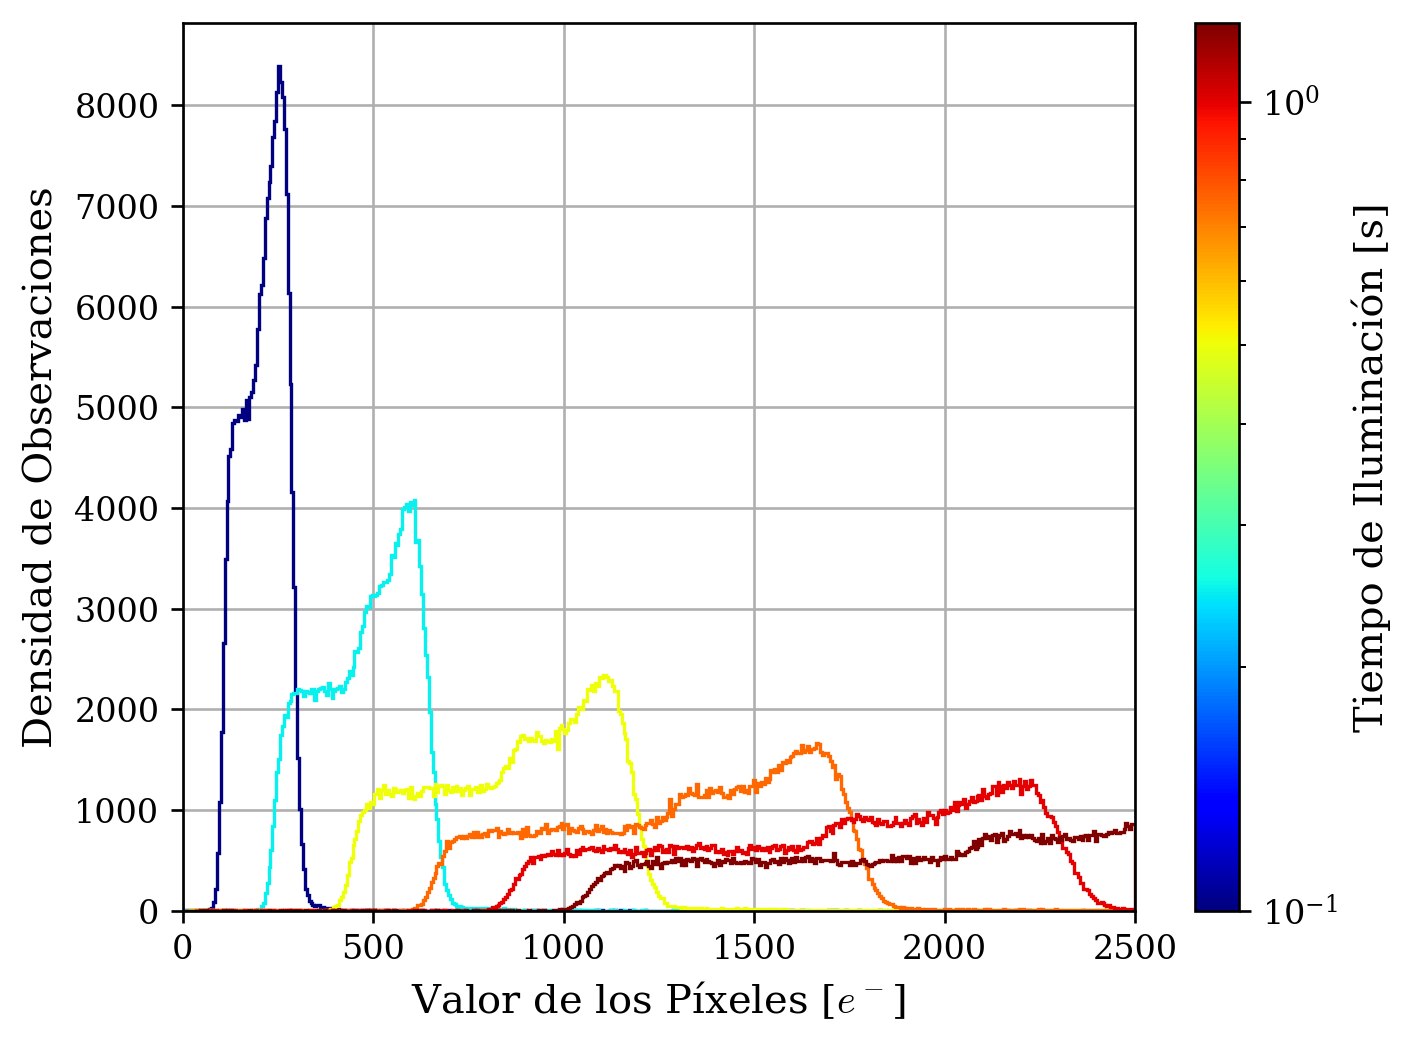

In [75]:
nfilms = 0
if nfilms == 0:
    data_dir = 'skipper_data/TRAPS/19OCT2023'
elif nfilms in [1, 2]:
    data_dir = 'skipper_data/TRAPS/26OCT2023'


min_val = 0  # e⁻
tope = 2500  # e⁻
n_bins = 500
frame_to_plot = 0
exposure_times = np.array(list(sgn_files[f"{nfilms}film"].keys()))

fig, ax = plt.subplots(1, 1)

norm = LogNorm(
        exposure_times.min(),
        exposure_times.max(),
    )
colormap = plt.cm.ScalarMappable(norm, "jet")
for e in exposure_times:
    lighted_image = fits.open(f'{data_dir}/{sgn_files[f"{nfilms}film"][e]}')
    lighted_image = correct_overscan(lighted_image)
    background_image = fits.open(f'{data_dir}/{bkg_files[f"{nfilms}film"][e]}')
    background_image = correct_overscan(background_image)

    test_data = lighted_image[frame_to_plot].data
    r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
    test_data = test_data[:-r_overscan, PRESCAN_PIX:-c_overscan].flatten()
    if min_val is None:
        min_val = np.nanmin(test_data)
    if tope is None:
        tope = np.nanmax(test_data)
    cuentas, valores, _ = ax.hist(
        test_data[
            (test_data > min_val * ganancia[frame_to_plot])
            & (test_data < tope * ganancia[frame_to_plot])
        ] / ganancia[frame_to_plot],
        bins=np.linspace(min_val, tope, n_bins),
        histtype="step",
        color=colormap.to_rgba(e),
        label=f"{e} s",
        # density=True,
    )
    # ax.axvline(test_data.mean() / ganancia[frame_to_plot], color=colormap.to_rgba(e), linestyle="--")
    # ax.axvline((test_data.mean() + 2*test_data.std())  / ganancia[frame_to_plot],
    #            color=colormap.to_rgba(e), linestyle=":")
    # ax.axvline((test_data.mean() - 2*test_data.std())  / ganancia[frame_to_plot],
    #            color=colormap.to_rgba(e), linestyle=":")
ax.grid(True)
# ax.legend(title="Exposure Time")
# plt.colorbar(colormap, label="Tiempo de Iluminación [s]", ax=ax)
plt.colorbar(colormap, label="Tiempo de Iluminación [s]", ax=ax)
# ax.set_yscale("log")
# ax.set_xscale("log")
# ax.set_yticks(10**np.arange(5))
ax.set_xlim(min_val, tope)
ax.set_xlabel("Valor de los Píxeles [$e^-$]")
ax.set_ylabel("Densidad de Observaciones")
plt.show()

In [80]:
frame_to_plot = 0
nfilms = 2
if nfilms == 0:
    data_dir = 'skipper_data/TRAPS/19OCT2023'
elif nfilms in [1, 2]:
    data_dir = 'skipper_data/TRAPS/26OCT2023'

exposure_times = np.array(list(sgn_files[f"{nfilms}film"].keys()))

def gaussiana(x, mu, sigma, a):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

carga_media = []
ancho_dist = []
for e in exposure_times:
    lighted_image = fits.open(f'{data_dir}/{sgn_files[f"{nfilms}film"][e]}')
    lighted_image = correct_overscan(lighted_image)
    background_image = fits.open(f'{data_dir}/{bkg_files[f"{nfilms}film"][e]}')
    background_image = correct_overscan(background_image)
    test_data = lighted_image[frame_to_plot].data
    r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
    test_data = test_data[:-r_overscan, PRESCAN_PIX:-c_overscan].flatten()
    if nfilms in [1, 2]:
        min_val = test_data.mean() - 3*test_data.std()
        max_val = test_data.mean() + 3*test_data.std()
        cuentas, valores = np.histogram(test_data, bins=np.linspace(min_val, max_val, n_bins))
        popt, pcov = curve_fit(gaussiana, valores[:-1], cuentas, p0=[test_data.mean(), test_data.std(), cuentas.max()])
        carga_media.append(popt[0] / ganancia[frame_to_plot])
        ancho_dist.append(popt[1] / ganancia[frame_to_plot])
    else:
        carga_media.append(test_data.mean() / ganancia[frame_to_plot])
        ancho_dist.append(test_data.std() / ganancia[frame_to_plot])

Carga Media
Pendiente: 116.6 ± 0.2 e⁻/s
Ordenada : 6.0 ± 1 e⁻
Ancho de la Distribución
Pendiente: 5.7 ± 0.08 e⁻/s
Ordenada : 8.3 ± 0.7 e⁻


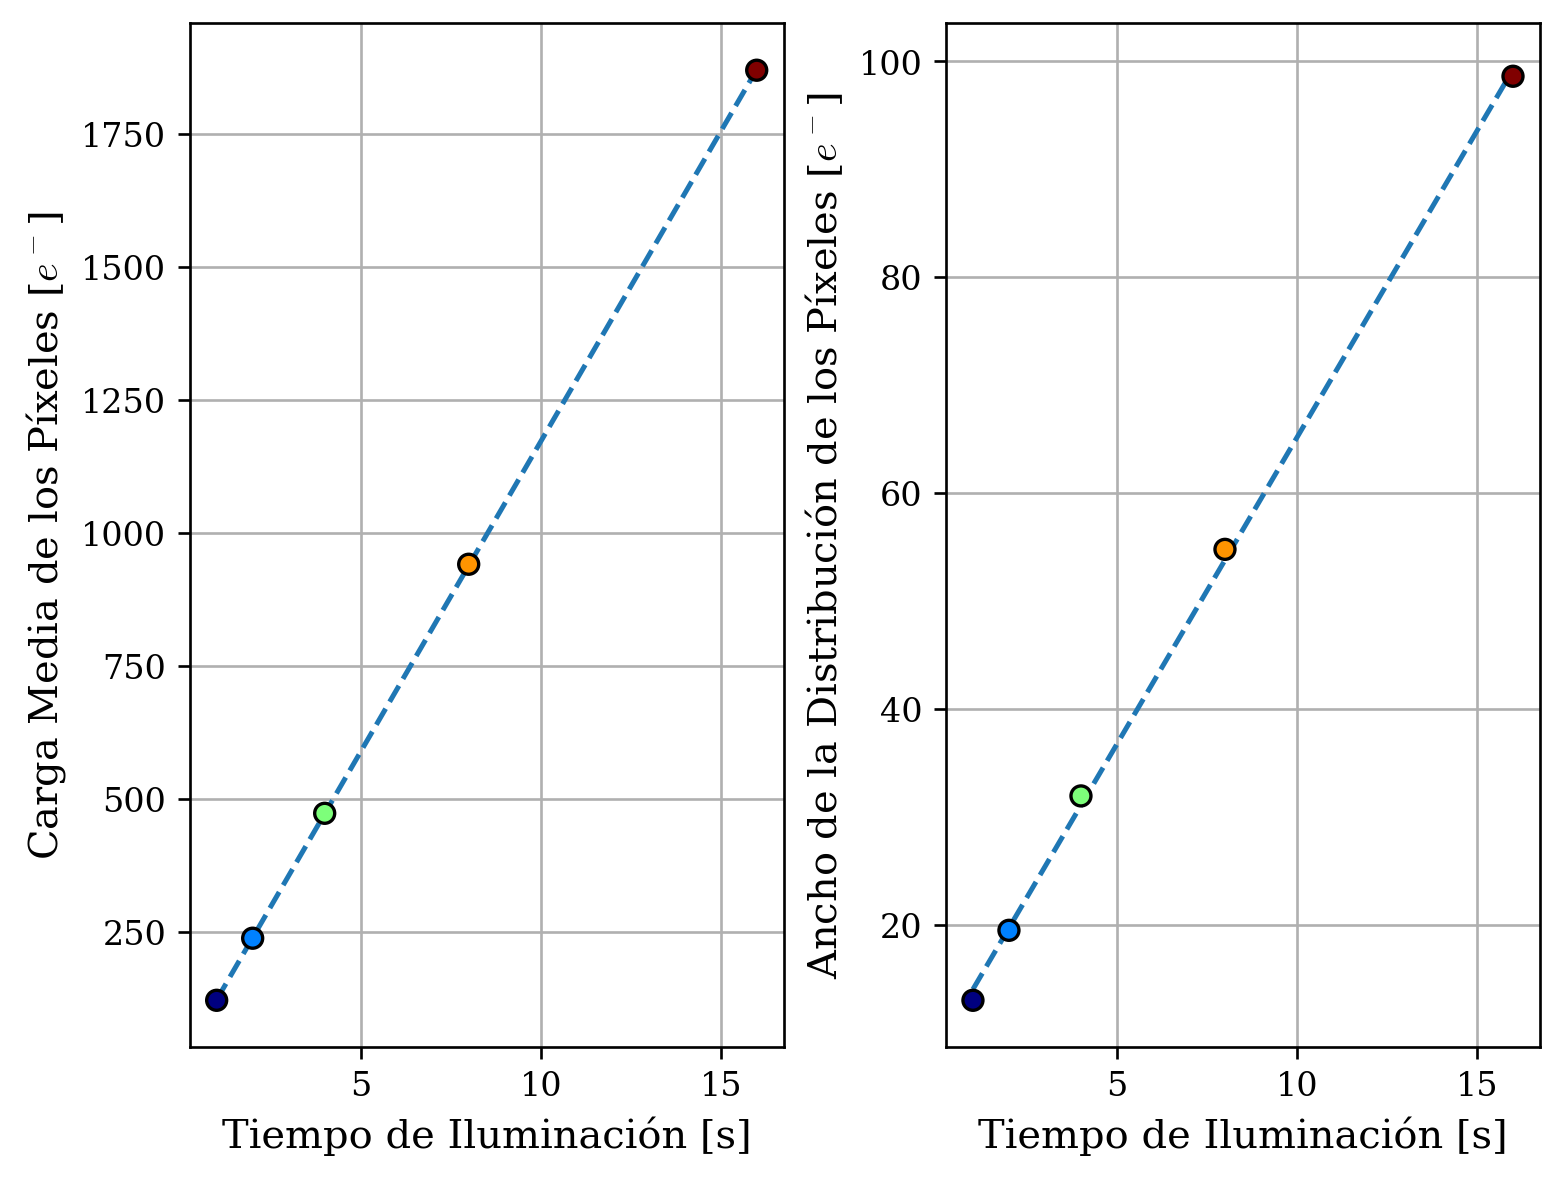

In [81]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

for ax, vals, tag in zip(axs, [carga_media, ancho_dist], ["Carga Media", "Ancho de la Distribución"]):
    vals = np.array(vals)
    ax.scatter(exposure_times, vals, c=np.log2(exposure_times), cmap="jet", edgecolors="k", zorder=10)
    popt, pcov = curve_fit(lambda x, a, b: a*x + b, exposure_times, vals)
    perr = np.sqrt(np.diag(pcov))
    print(tag)
    print(f"Pendiente: {popt[0]:.1f} ± {perr[0]:.1g} e⁻/s")
    print(f"Ordenada : {popt[1]:.1f} ± {perr[1]:.1g} e⁻")
    ax.plot(exposure_times, popt[0]*exposure_times + popt[1], linestyle="--", zorder=3)
    ax.grid(True)
    ax.set_xlabel("Tiempo de Iluminación [s]")
    ax.set_ylabel(f"{tag} de los Píxeles [$e^-$]")

# axs[-1].scatter(carga_media, ancho_dist, c=np.log2(exposure_times), cmap="jet", edgecolors="k", zorder=10)
# popt, pcov = curve_fit(lambda x, a, b: a*x + b, carga_media, ancho_dist)
# perr = np.sqrt(np.diag(pcov))
# print("Relación entre Carga Media y Ancho de la Distribución")
# print(f"Pendiente: {popt[0]:.1f} ± {perr[0]:.1g} e⁻/s")
# print(f"Ordenada : {popt[1]:.1f} ± {perr[1]:.1g} e⁻")
# axs[-1].plot(carga_media, popt[0]*np.array(carga_media) + popt[1], linestyle="--", zorder=3)
# axs[-1].grid(True)
# axs[-1].set_xlabel(f"Carga Media de los Píxeles [$e^-$]")
# axs[-1].set_ylabel(f"Ancho de la Distribución de los Píxeles [$e^-$]")
plt.show()

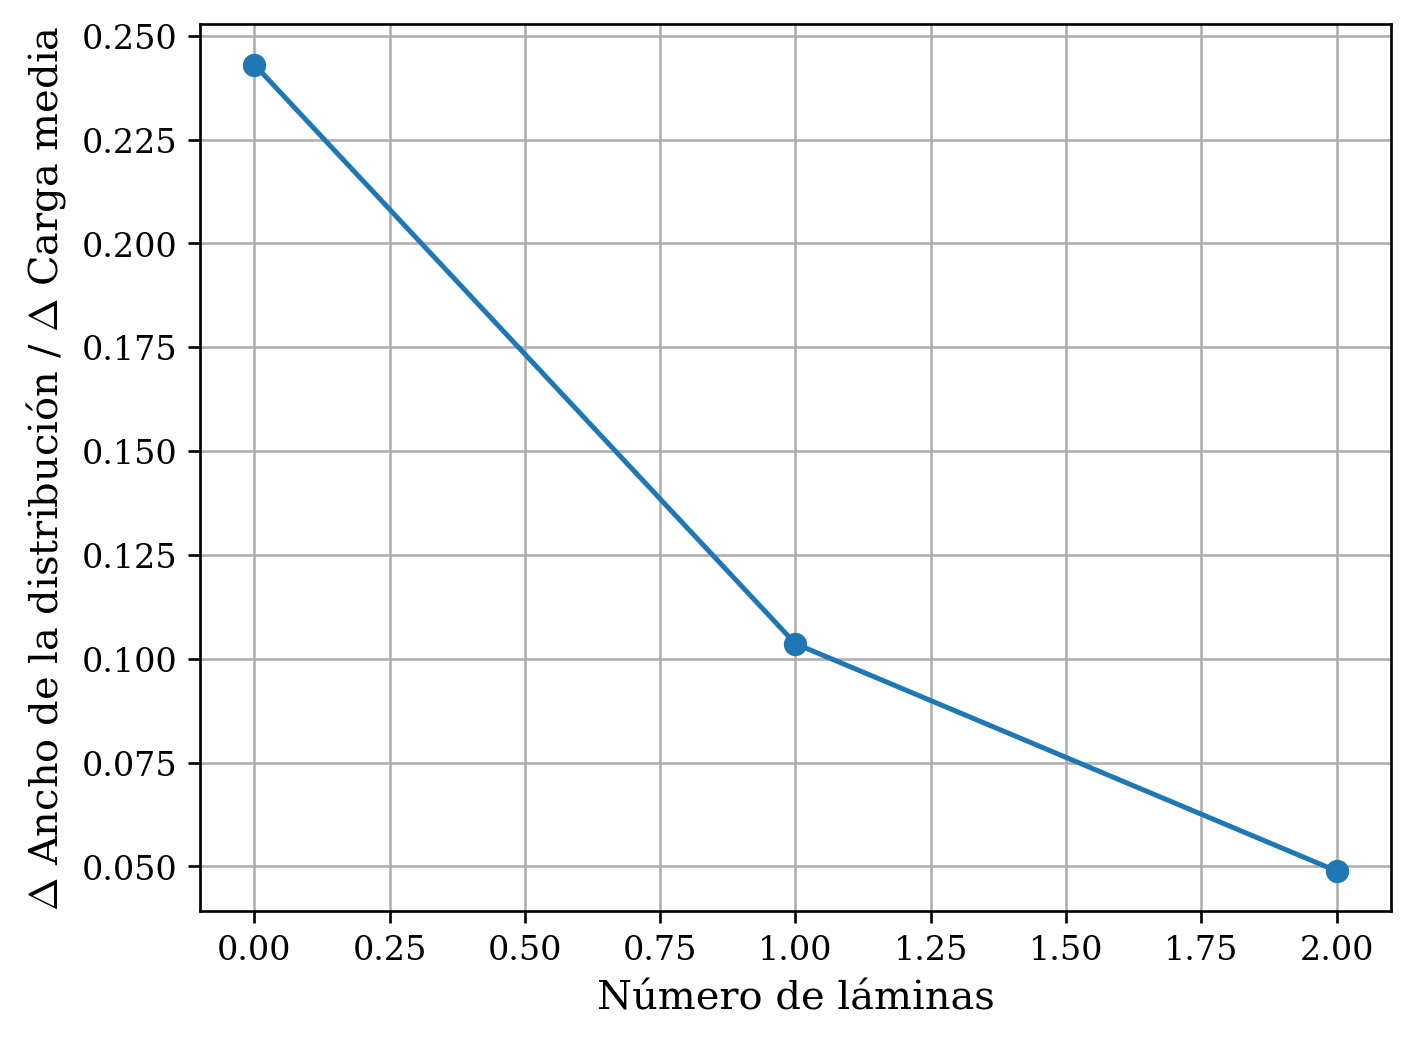

In [84]:
p_mean = [1654, 291.5, 116.6]
p_dist = [402, 30.2, 5.7]

p_optim = [std/avg for avg, std in zip(p_mean, p_dist)]

plt.plot(p_optim, "o-")
plt.grid()
plt.xlabel("Número de láminas")
plt.ylabel("$\Delta$ Ancho de la distribución / $\Delta$ Carga media")
plt.show()

# Estudio de homogeneidad

In [21]:
t_ilum = 0.25
lighted_image = fits.open(f'{data_dir}/{sgn_files[t_ilum]}')
lighted_image = correct_overscan(lighted_image)
background_image = fits.open(f'{data_dir}/{bkg_files[t_ilum]}')
background_image = correct_overscan(background_image)
test_frame = lighted_image[2].data
r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
test_frame = test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan]
homogeneidad_local_col = np.zeros_like(test_frame)
homogeneidad_local_row = np.zeros_like(test_frame)

for i in range(1, np.shape(test_frame)[0]-1 ):
    for j in range(1, np.shape(test_frame)[1]-1):
        grad_vertical = (
            +2*test_frame[i, j+1]- 2*test_frame[i, j-1] 
            +test_frame[i+1, j+1]+ test_frame[i-1, j+1]
            -test_frame[i+1, j-1]- test_frame[i-1, j-1] 
        )
        grad_horizontal = (
            +2*test_frame[i+1, j]- 2*test_frame[i-1, j] 
            +test_frame[i+1, j+1]+ test_frame[i+1, j-1]
            -test_frame[i-1, j+1]- test_frame[i-1, j-1] 
        )
        homogeneidad_local_col[i, j] = grad_vertical
        homogeneidad_local_row[i,j] = grad_horizontal
        

         


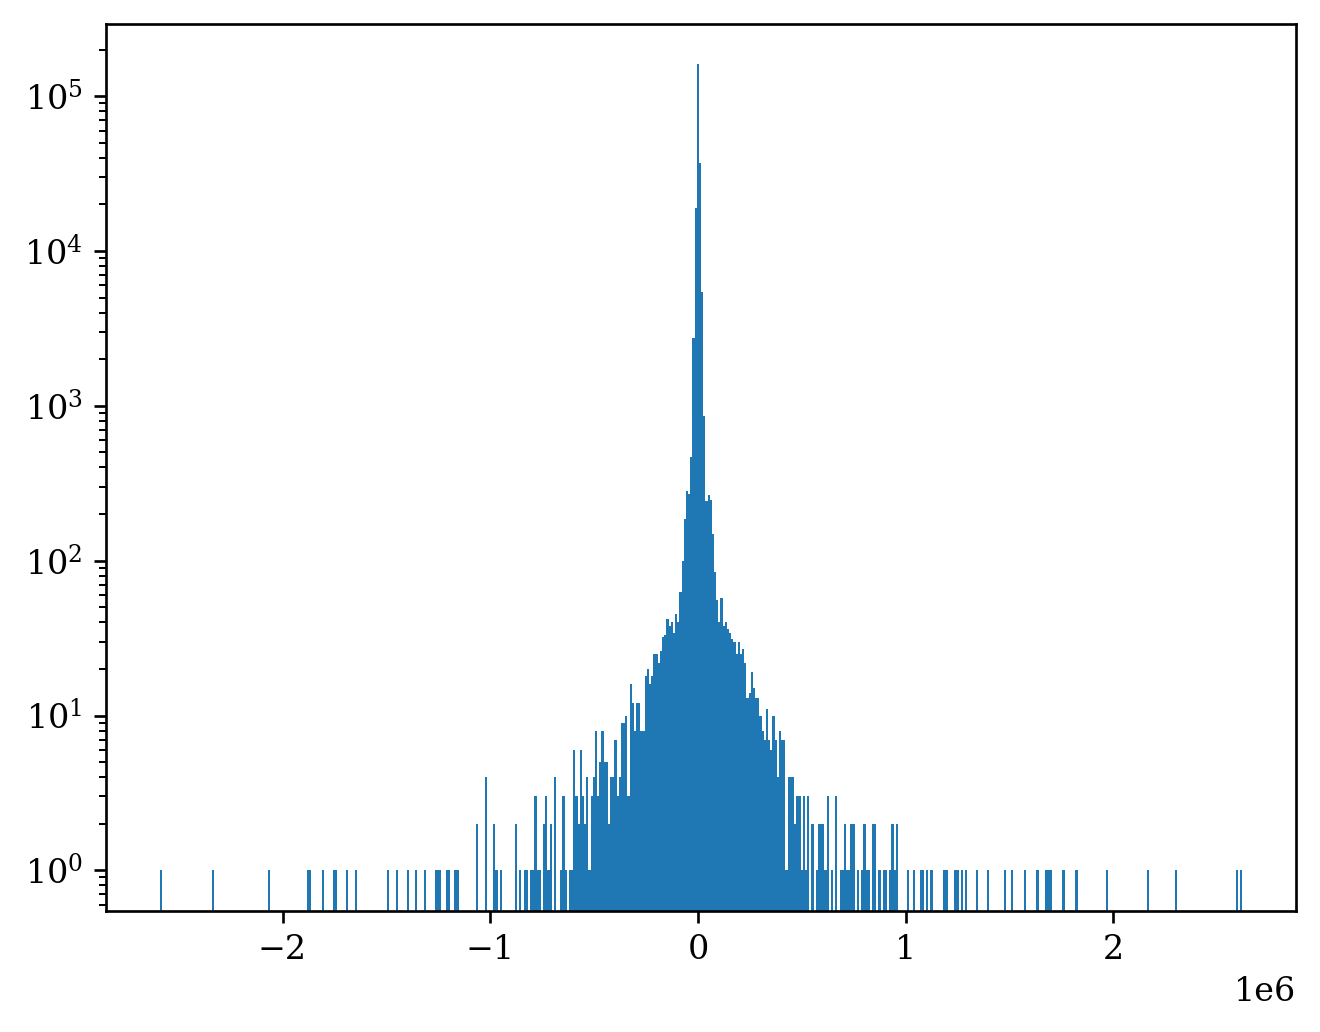

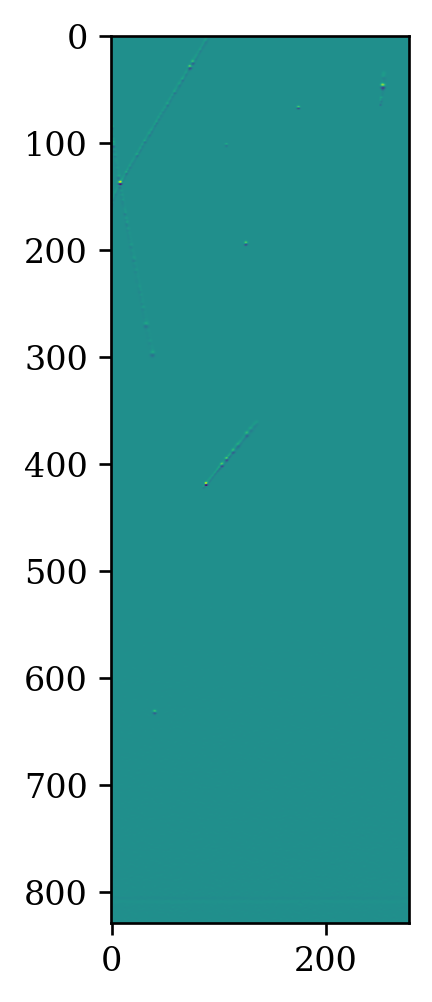

In [23]:
plt.hist(homogeneidad_local_row.flatten(), bins =500)
plt.yscale("log")
plt.show()
plt.imshow(homogeneidad_local_row)

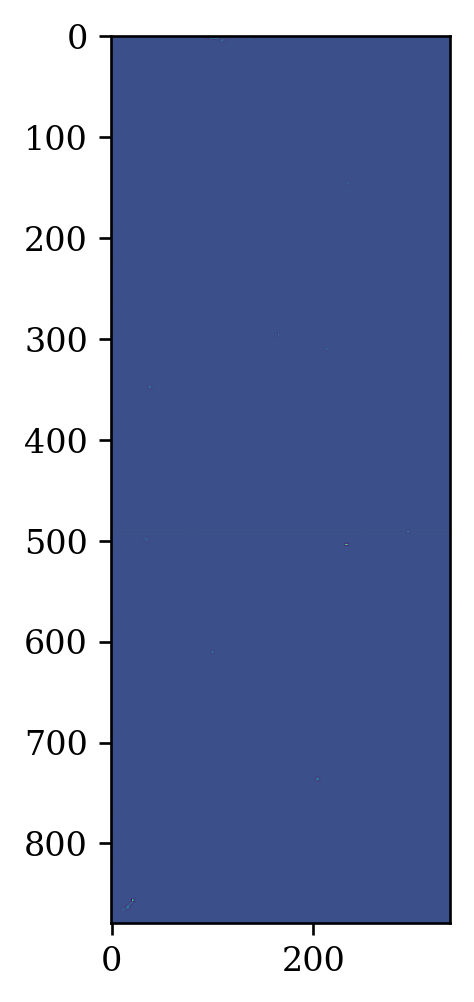

In [10]:
plt.imshow(homogeneidad_local)

# Detección de dipolos

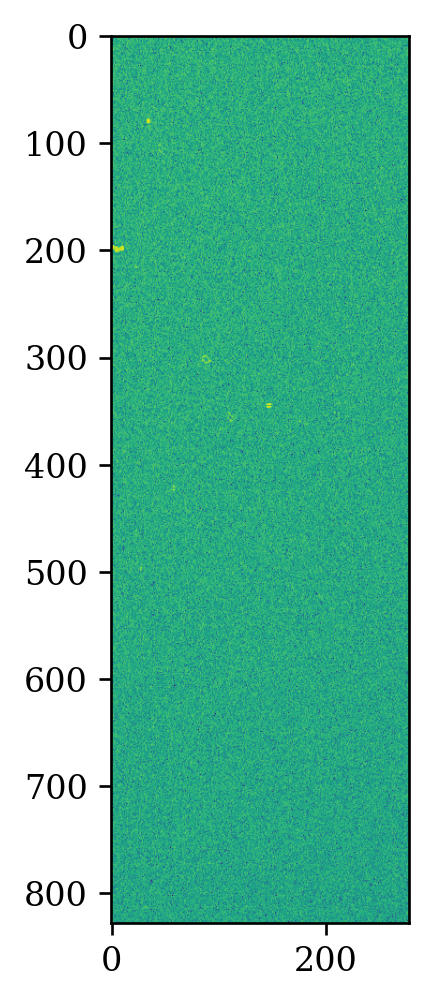

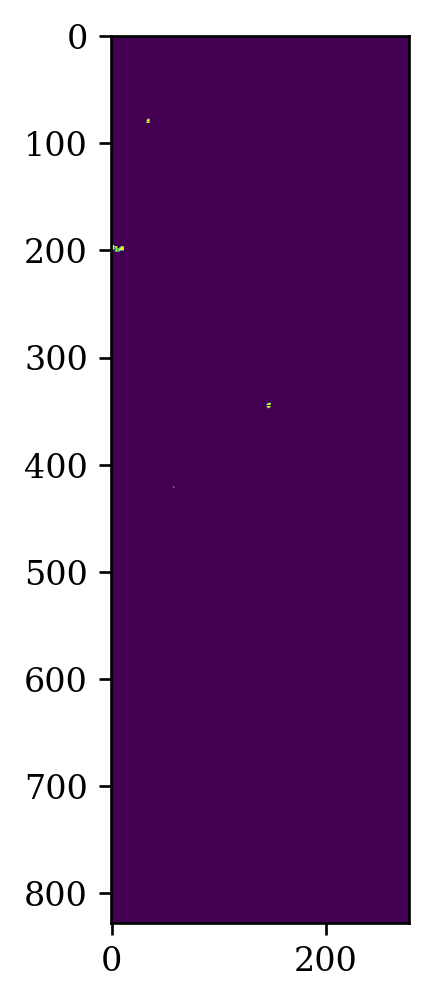

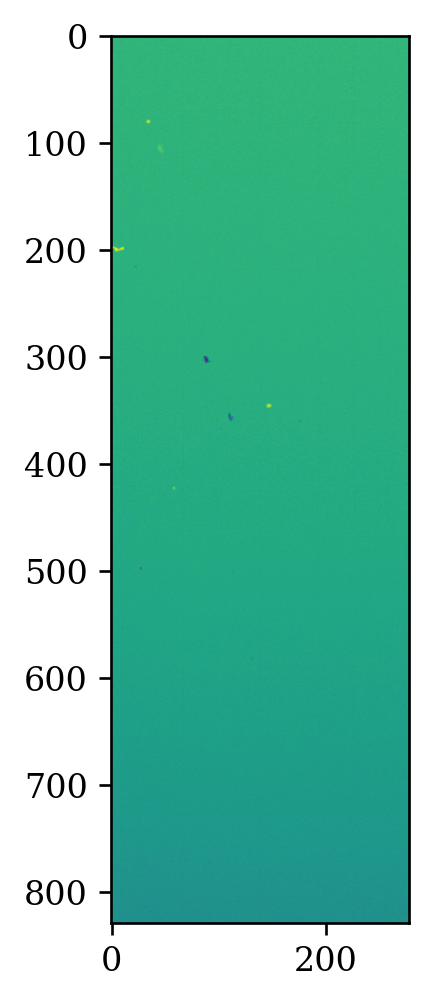

In [41]:
t_ilum = 0.25
threshold = 10**5
lighted_image = fits.open(f'{data_dir}/{sgn_files[t_ilum]}')
lighted_image = correct_overscan(lighted_image)
background_image = fits.open(f'{data_dir}/{bkg_files[t_ilum]}')
background_image = correct_overscan(background_image)
test_frame = lighted_image[0].data
r_overscan, c_overscan = get_rowcol_ovserscan(lighted_image)
test_frame = test_frame[:-r_overscan, PRESCAN_PIX:-c_overscan]

dif = np.diff(test_frame, axis=0, )
mascara_dipolos = np.zeros_like(dif, dtype=int)



mascara_dipolos[np.abs(dif)<threshold] = 0
mascara_dipolos[np.abs(dif)>=threshold] = 1

#
# filtro_dipolos
plt.imshow(np.log(np.abs(dif)+1))
plt.show()
plt.imshow(np.log(np.abs(mascara_dipolos)+1))
plt.show()
plt.imshow(np.log(np.abs(test_frame)+1))